# Capstone Step 7

## imports and configs

In [120]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, TunedThresholdClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, root_mean_squared_error
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, balanced_accuracy_score
from scipy.stats import uniform
from pprint import pprint as pp

import multiprocessing
print("CPUs available for n_jobs in estimators: ", multiprocessing.cpu_count())

# I have 16 in my system, so leaving 2 for other tasks
CPUS_FOR_JOBS = multiprocessing.cpu_count() - 3

pd.options.display.max_columns = 999

CPUs available for n_jobs in estimators:  16


In [56]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def exit_notebook(): raise StopExecution

In [57]:
# load the pickle files
pickle_x_file_name = "capstone_x.pkl"
pickle_y_file_name = "capstone_y.pkl"

if os.path.exists(pickle_x_file_name) :
    print("Reading existing well start and end dates pickle...")
    X_df = pd.read_pickle(pickle_x_file_name)
    y_df = pd.read_pickle(pickle_y_file_name)
else:
    print("Can't locate pickle files in current directory; try running the capstone step 5 EDA first to generate the pickle files")
    exit_notebook()



Reading existing well start and end dates pickle...


In [58]:
X_df

,CalcIdleYear,IdleFlag,IdleFees,SpudYear_Model,WellStatus_Canceled,WellStatus_Idle,WellStatus_New,WellStatus_Unknown,WellType_CH,WellType_DG,WellType_DH,WellType_GAS,WellType_GD,WellType_GS,WellType_INJ,WellType_LG,WellType_Multi,WellType_OB,WellType_OG,WellType_PM,WellType_SC,WellType_SF,WellType_STR,WellType_UNK,WellType_WD,WellType_WF,WellType_WS,CountyName_Butte,CountyName_Colusa,CountyName_Contra Costa,CountyName_Fresno,CountyName_Glenn,CountyName_Humboldt,CountyName_Imperial,CountyName_Kern,CountyName_Kings,CountyName_Lake,CountyName_Lassen,CountyName_Los Angeles,CountyName_Los Angeles Offshore,CountyName_Madera,CountyName_Marin,CountyName_Merced,CountyName_Monterey,CountyName_Napa,CountyName_Orange,CountyName_Orange Offshore,CountyName_Riverside,CountyName_Sacramento,CountyName_San Benito,CountyName_San Bernardino,CountyName_San Diego,CountyName_San Joaquin,CountyName_San Luis Obispo,CountyName_San Mateo,CountyName_San Nicolas Island Offshore,CountyName_Santa Barbara,CountyName_Santa Barbara Offshore,CountyName_Santa Clara,CountyName_Siskiyou,CountyName_Solano,CountyName_Stanislaus,CountyName_Sutter,CountyName_Tehama,CountyName_Tulare,CountyName_Ventura,CountyName_Ventura Offshore,CountyName_Yolo,CountyName_Yuba,isDirectio_Y,OperatorBin_11-100,OperatorBin_101-250,OperatorBin_251-1250,OperatorBin_1251+
0,-2.031209,1,2.047394,-4.322393,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,-0.299460,1,-0.054760,0.303799,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,-0.299460,1,-0.054760,0.351005,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,-0.491876,1,-0.054760,0.445417,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,0.181581,0,-0.580299,-0.215468,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,0.903143,0,-0.580299,-0.168261,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [59]:
y_df

0         1
1         1
2         1
3         1
4         0
         ..
241872    1
241873    1
241874    1
241875    1
241890    0
Name: AtRisk, Length: 110040, dtype: int64

In [60]:
# confirm the lengths are the same
assert(len(X_df)==len(y_df))
X_df.shape

(110040, 74)

# The Baseline for comparison
Hyperparameter tuning in Step 5 showed that the following parameters yielded the best accuracy with Logistic Regression:
- C = 2.9577
- max_iter = 150
- penalty = 'l1'
- solver = 'saga'

# The Pipeline for testing
The first entry will be the same Baseline Logistic Regression model for comparison, and then include Random Forest Classifier, Histogram Gradient Boosting Classifier and  State Vector Machine estimators. First I'll run the defaults with KFold cross validation to get a sense of the spread of outcomes, then I'll run a full GridSearchCV for hyperparameter optimization.

In [61]:
# Split the dataset
# Need to do this before the Scaling
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, stratify=y_df, test_size=0.3, random_state=42)

In [68]:
# A selection of classifiers to try
models = {
    "LogReg" : {
        'model':LogisticRegression(n_jobs=CPUS_FOR_JOBS),
        'params': {
            'C' : [1.5, 2, 2.5, 3, 3.5],
            'penalty' : ['l1','l2'],
            'max_iter' : [250,350,500],
            'solver' : ['saga','liblinear','libfgs'],
            'class_weight' : ['balanced',None]
        }
    },
    "RF" : {
        'model': RandomForestClassifier(n_jobs=CPUS_FOR_JOBS),
        'params':{
            'n_estimators': np.arange(50,300,50),
            'max_depth': np.arange(1,20,2),
            'min_samples_split': np.arange(1,20,2)
        }
    },
    "HGB" : {
        'model' : HistGradientBoostingClassifier(),
        'params' : {
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': np.arange(1,20,2),
            'min_samples_leaf': np.arange(1,20,2)
        }
    },
    "SVM": {
        'model': SVC(),
        'params':{
            'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}


In [63]:
results = []
kf = KFold(n_splits=6, random_state=42, shuffle=True)

for name, mp in models.items():

    # perform cross-validation with default model settings
    cv_scores = cross_val_score(mp['model'], X_train, y_train, cv=kf)

    results.append(cv_scores)

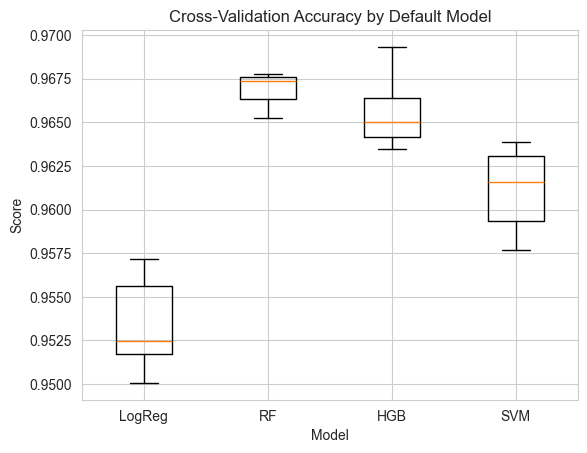

In [64]:
# Show the cross-validation results, since I didn't specify the scoring method, it uses the estimator's default scoring method
plt.boxplot(results, tick_labels=models.keys())
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Cross-Validation Accuracy by Default Model')
plt.show()

## Run the GridSearch for all the models, it seems all 4 of these classifiers would be a reasonably good fit.
After the GridSearch, I'll look at the False Pos/False Neg to see if these other methods have an improvement over baseline.

In [69]:
grid_results = []
grid_scores = {}
for name, mp in models.items():

    print(f"Running grid search for {name}...")
    grid_search = GridSearchCV(estimator=mp['model'], param_grid=mp['params'], cv=kf, scoring='accuracy', n_jobs=CPUS_FOR_JOBS, verbose=1)
    grid_search.fit(X_train, y_train)

    grid_results.append({
        'model':name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    })

    # store all the cross validation scores for a boxplot
    grid_scores[name] = grid_search.cv_results_['mean_test_score']

    print(f"Best Score for {name}: {grid_search.best_score_}")
    print(f"Best Params for {name}: {grid_search.best_params_}")


Running grid search for LogReg...
Fitting 6 folds for each of 180 candidates, totalling 1080 fits


C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.

Best Score for LogReg: 0.9536012878433815
Best Params for LogReg: {'C': 2, 'class_weight': None, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Running grid search for RF...
Fitting 6 folds for each of 500 candidates, totalling 3000 fits


C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
300 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation

Best Score for RF: 0.9689074102923612
Best Params for RF: {'max_depth': np.int64(19), 'min_samples_split': np.int64(3), 'n_estimators': np.int64(200)}
Running grid search for HGB...
Fitting 6 folds for each of 300 candidates, totalling 1800 fits
Best Score for HGB: 0.9661941112322792
Best Params for HGB: {'learning_rate': 0.1, 'max_depth': np.int64(17), 'min_samples_leaf': np.int64(11)}
Running grid search for SVM...
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Best Score for SVM: 0.9636885288466531
Best Params for SVM: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}


In [70]:
pp(grid_results)


[{'best_estimator': LogisticRegression(C=2, max_iter=500, n_jobs=14, penalty='l1',
                   solver='liblinear'),
  'best_params': {'C': 2,
                  'class_weight': None,
                  'max_iter': 500,
                  'penalty': 'l1',
                  'solver': 'liblinear'},
  'best_score': np.float64(0.9536012878433815),
  'model': 'LogReg'},
 {'best_estimator': RandomForestClassifier(max_depth=np.int64(19), min_samples_split=np.int64(3),
                       n_estimators=np.int64(200), n_jobs=14),
  'best_params': {'max_depth': np.int64(19),
                  'min_samples_split': np.int64(3),
                  'n_estimators': np.int64(200)},
  'best_score': np.float64(0.9689074102923612),
  'model': 'RF'},
 {'best_estimator': HistGradientBoostingClassifier(max_depth=np.int64(17),
                               min_samples_leaf=np.int64(11)),
  'best_params': {'learning_rate': 0.1,
                  'max_depth': np.int64(17),
                  'min_samples_l

In [71]:
# the grid_scores dict has result arrays of different lengths, so have to iterate over them and pad the shorter ones with None
# this will then be fed into a boxplot
grid_cols = []
grid_scores_df = pd.DataFrame()

# find the max length we need to set
max_len = 0
for v in grid_scores.values():
    max_len = max(max_len, len(v))

print(f"max grid scores array length = {max_len}")

for k, i in grid_scores.items():
    # pad each array with extra Nones
    padded_array = list(i) + [None]*(max_len - len(i))
    # append it to the dataframe
    grid_scores_df[k] = padded_array

grid_scores_df

max grid scores array length = 500


,LogReg,RF,HGB,SVM
0,0.916952,NaN,0.881835,0.948006
1,0.916926,NaN,0.881835,0.949759
2,NaN,NaN,0.881835,0.948006
3,0.916887,NaN,0.881835,0.929571
4,0.916913,NaN,0.881835,0.949603
...,...,...,...,...
495,NaN,0.966428,NaN,NaN
496,NaN,0.966869,NaN,NaN
497,NaN,0.967064,NaN,NaN
498,NaN,0.967077,NaN,NaN


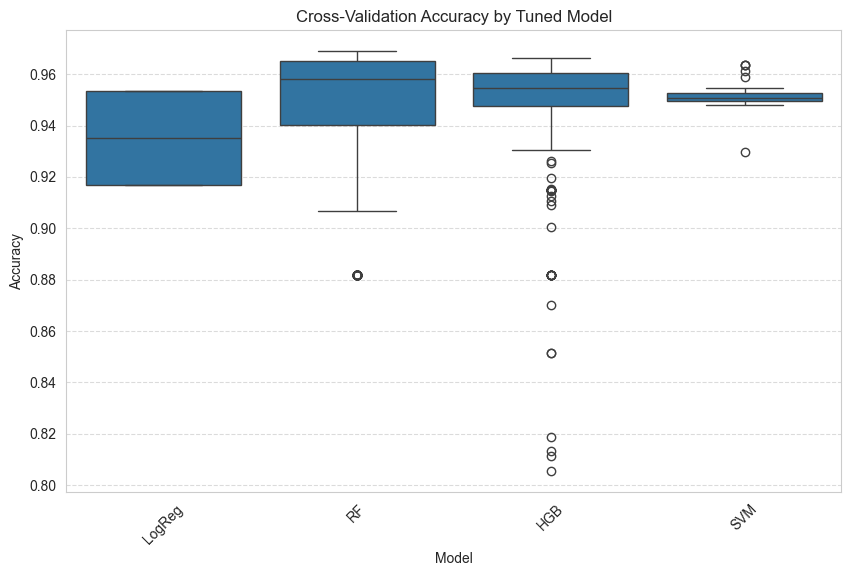

In [72]:
# Melt the DataFrame for easier plotting with seaborn
scores_melted = grid_scores_df.melt(var_name='model', value_name='accuracy')
scores_melted

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='accuracy', data=scores_melted)
plt.title('Cross-Validation Accuracy by Tuned Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Results so far** Random Forest is still the best candidate purely from a scoring perspective after hyperparameter tuning. Next we'll look at metrics of the test sets with the best estimators.

C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 14.
  warnings.warn(


LogReg best estimator test set score: 0.95259
RF best estimator test set score: 0.96847
HGB best estimator test set score: 0.96483
SVM best estimator test set score: 0.96362


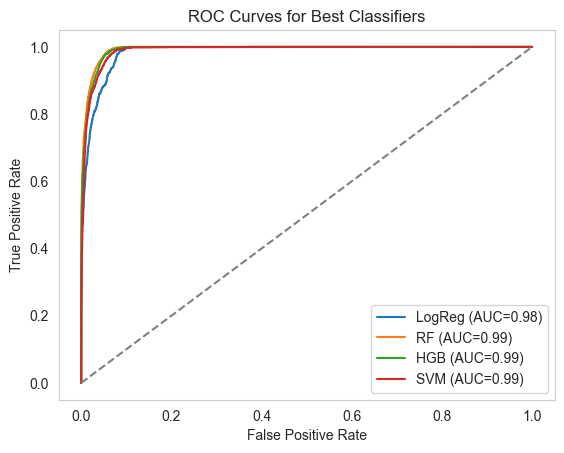

In [73]:
# Calculate mean squared error for each model
# I was trying with RMSE, but that's a better fit for continuous regression models.
# For classifiers, accuracy_score is likely a better fit
test_results = {}
for i in grid_results:

    # fit the model to the training data
    model = i['best_estimator']
    model.fit(X_train, y_train)

    # use the test set to make predictions
    y_pred = model.predict(X_test)

    # score
    test_accuracy = accuracy_score(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_class_report = classification_report(y_test, y_pred)
    test_conf_matrix = confusion_matrix(y_test, y_pred)

    # create the ROC data for curves, either with predict_proba or the decision_function
    if hasattr(model, 'predict_proba'):
        y_prob_pred = model.predict_proba(X_test)[:,1]
    else:
        y_prob_pred = model.decision_function(X_test)

    # Compute the ROC curve and AUC score
    test_fpr, test_tpr, _ = roc_curve(y_test, y_prob_pred)
    test_auc_score = roc_auc_score(y_test, y_prob_pred)

    # plot the ROC immediately for comparison
    plt.plot(test_fpr, test_tpr, label=f"{i['model']} (AUC={test_auc_score:.2f})")

    # save the rest of the metrics for further analysis
    print(f"{i['model']} best estimator test set score: {test_accuracy:.5f}")

    test_results[i['model']] = {
        'test_accuracy' : test_accuracy,
        'test_rmse' : test_rmse,
        'test_auc_score' : test_auc_score,
        'test_class_report' : test_class_report,
        'test_conf_matrix' : test_conf_matrix
    }

# this has to be done all in one Jupyter cell because the notebook publishes the chart at the end anyway
# ROC plot formatting, data was already pushed to plt in the for loop above
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Classifiers")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Analysis
Including the ROC curve generated above at the end of the GridSearchCV runs, we can see that all 4 models perform similarly, with **Random Forest** being the best of the bunch by a point or two.

In [81]:
# Show the test score results from the best models
results_df = pd.DataFrame(test_results)
results_df


,LogReg,RF,HGB,SVM
test_accuracy,0.952593,0.968466,0.964831,0.963619
test_rmse,0.217731,0.177578,0.187534,0.190737
test_auc_score,0.984296,0.992883,0.991578,0.989271
test_class_report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
test_conf_matrix,"[[28419, 692], [873, 3028]]","[[28645, 466], [575, 3326]]","[[28598, 513], [648, 3253]]","[[28561, 550], [651, 3250]]"


## Confusion Matrices

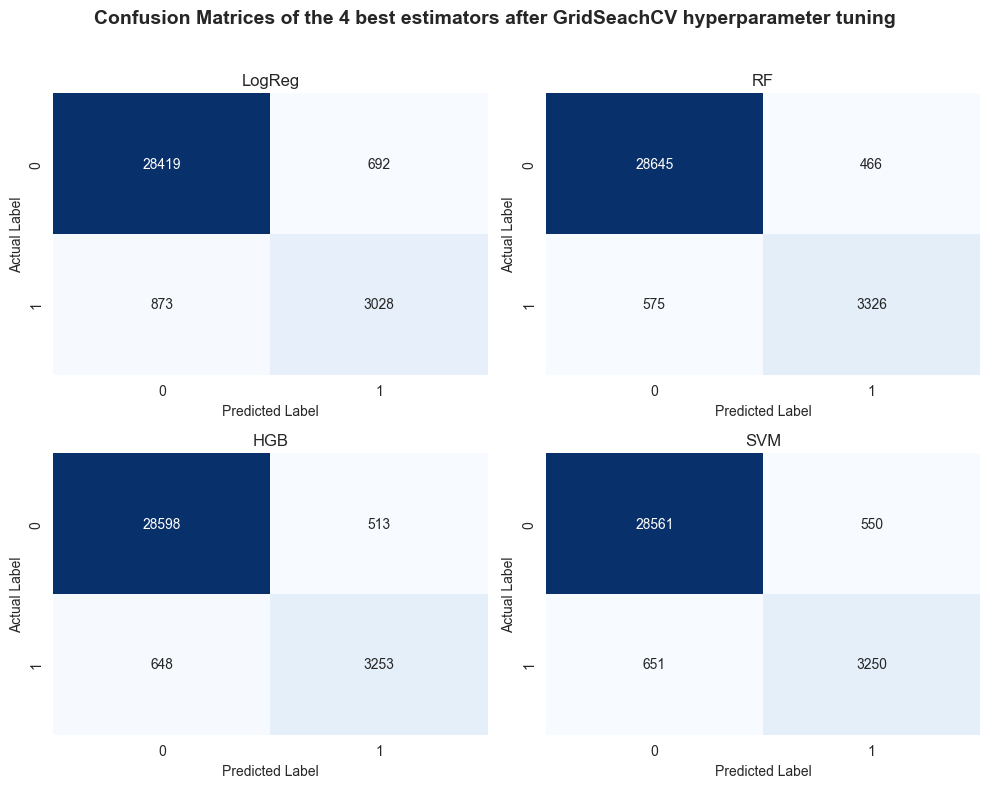

In [95]:
# plot the 4 confusion matrices in a grid
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

cm_row = results_df.loc['test_conf_matrix']
for ax, (name, cm) in zip(axes, cm_row.T.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

plt.suptitle("Confusion Matrices of the 4 best estimators after GridSeachCV hyperparameter tuning", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Based on the Confusion Matrix results of each of the estimators, Random Forest has the best ratio of False Positives & Negatives to the True Positives.

## Classification Reports

In [104]:
# the classification reports (they didn't survive packing in the dataframe)
for m, i in test_results.items():
    print(m, " :")
    print(i['test_class_report'])


LogReg  :
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     29111
           1       0.81      0.78      0.79      3901

    accuracy                           0.95     33012
   macro avg       0.89      0.88      0.88     33012
weighted avg       0.95      0.95      0.95     33012

RF  :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29111
           1       0.88      0.85      0.86      3901

    accuracy                           0.97     33012
   macro avg       0.93      0.92      0.92     33012
weighted avg       0.97      0.97      0.97     33012

HGB  :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29111
           1       0.86      0.83      0.85      3901

    accuracy                           0.96     33012
   macro avg       0.92      0.91      0.91     33012
weighted avg       0.96      0.96      0.96     330

After analyzing the classification reports, Random Forest is still clearly the best option, outperforming both HGB and SVM by a point in most of the metrics.

## Precision-Recall evaluation
Because the dataset is imbalanced, it seems like using Precision-Recall curves may be a better evaluation metric than ROC-AOC curves (which are all very similar). As I'm more interest in the Positive Predictions in this model, this will also be a better fit.

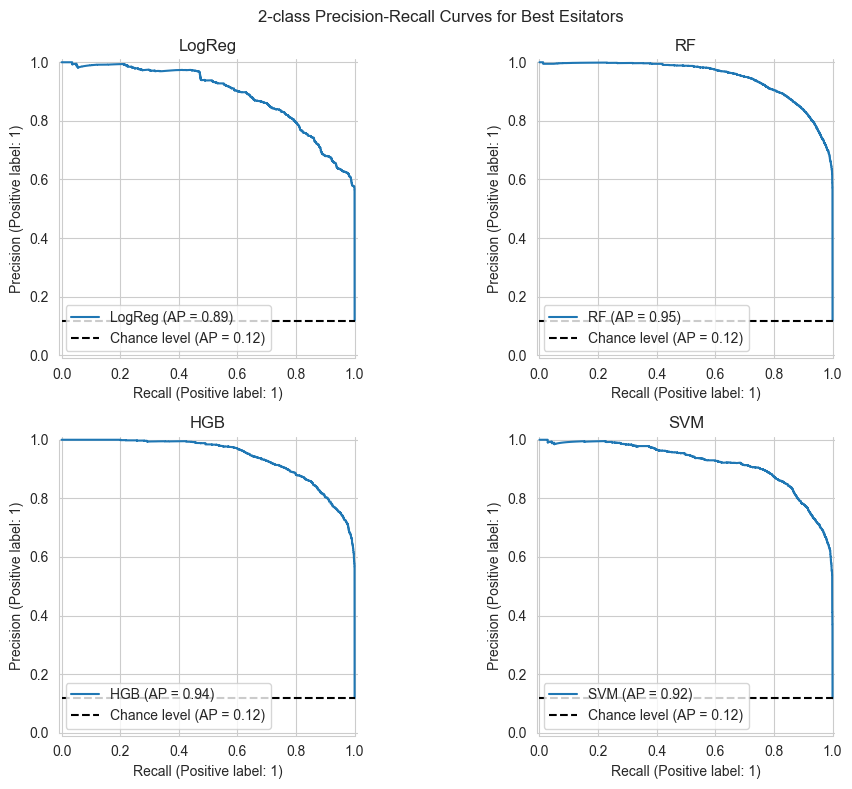

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

for ax, i in zip(axes, grid_results):
    model = i['best_estimator']
    display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=i['model'], plot_chance_level=True, despine=True, ax=ax)
    _ = display.ax_.set_title(i['model'])

plt.suptitle("2-class Precision-Recall Curves for Best Estimators")
plt.tight_layout()
plt.show()



# Model Tuning
First adjustment: Use Threshold Tuning with `TunedThresholdClassifierCV` to automatically find the best threshold

In [129]:
lr_model = grid_results[0]['best_estimator']
print(lr_model)
tuned_lr = TunedThresholdClassifierCV(lr_model, cv=5, scoring='balanced_accuracy', n_jobs=CPUS_FOR_JOBS, random_state=42, store_cv_results=True)
tuned_lr.fit(X_train, y_train)

y_tuned_lr_pred = tuned_lr.predict(X_test)
tuned_lr_score = balanced_accuracy_score(y_test, y_tuned_lr_pred)

print(f"original accuracy: {grid_results[0]['best_score']:.4f}, Balanced accuracy with tuned threshold: {tuned_lr_score:.4f}")
print(f"original threshold: 0.500, tuned threshold: {tuned_lr.best_threshold_:.4f}")


LogisticRegression(C=2, max_iter=500, n_jobs=14, penalty='l1',
                   solver='liblinear')


C:\Users\dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 14.
  warnings.warn(


original accuracy: 0.9536, Balanced accuracy with tuned threshold: 0.9504
original threshold: 0.500, tuned threshold: 0.0909


In [131]:
tuned_lr

TunedThresholdClassifierCV(cv=5,
                           estimator=LogisticRegression(C=2, max_iter=500,
                                                        n_jobs=14, penalty='l1',
                                                        solver='liblinear'),
                           n_jobs=13, random_state=42, store_cv_results=True)

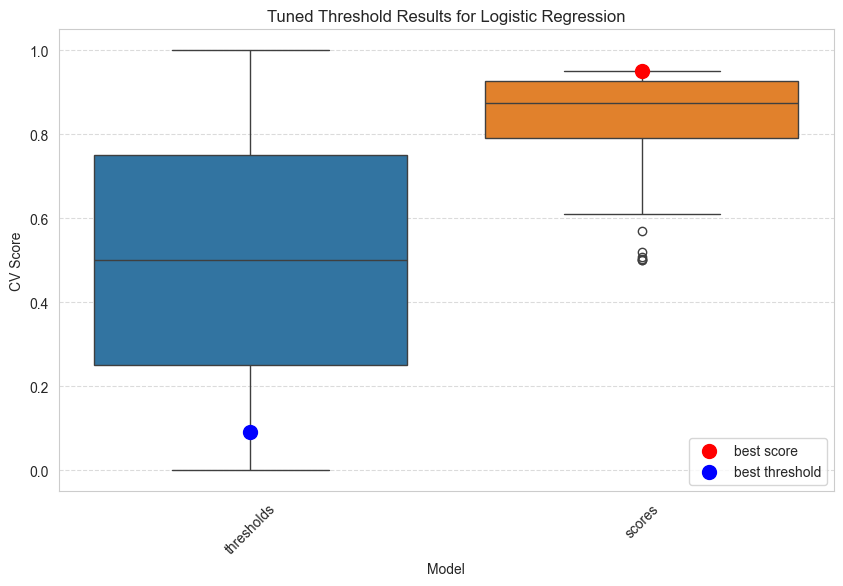

In [135]:
# Boxplot of the Threshold tuning CV results
plt.figure(figsize=(10, 6))
sns.boxplot(data=tuned_lr.cv_results_)
plt.title('Tuned Threshold Results for Logistic Regression')
plt.ylabel('CV Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.scatter(1, tuned_lr_score, color='red', s=100, zorder=3, label='best score')
plt.scatter(0, tuned_lr.best_threshold_, color='blue', s=100, zorder=3, label='best threshold')
plt.legend()
plt.show()


In [138]:
# the Tuned LR classification report
tuned_lr_class_report = classification_report(y_test, y_tuned_lr_pred)
print("Tuned Logistic Regression classification report:")
print(tuned_lr_class_report)
print("Compared to Prior Logistic Regression classification report:")
print(test_results['LogReg']['test_class_report'])
print("And compared to best-in-class Random Forest classification report:")
print(test_results['RF']['test_class_report'])


Tuned Logistic Regression classification report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     29111
           1       0.58      1.00      0.73      3901

    accuracy                           0.91     33012
   macro avg       0.79      0.95      0.84     33012
weighted avg       0.95      0.91      0.92     33012

Compared to Prior Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     29111
           1       0.81      0.78      0.79      3901

    accuracy                           0.95     33012
   macro avg       0.89      0.88      0.88     33012
weighted avg       0.95      0.95      0.95     33012

And compared to best-in-class Random Forest classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29111
           1       0.88      0.85      0.86      3901

    a

# Conclusions thus far:
- Random Forest gives the best overall balance of precision & accuracy without overfitting. Also, the number of False Positives & False Negatives is the least of the estimators compared here.
- Tuning Logistic regression yielded some interesting results, but has apparently overfit the model (to get 2% better on class 0 precision over Random Forest, we sacrifice precision on Class 1 by 30%). However, we have a Recall of 1.0 in Class 1, so we're also correctly identified all of the true Class 1s, with the addition of some False Positives. Comparing this to the RF Recall for Class 1 of 85%, I'm successfully captured 15% of the true Class 1s.
- This Tuned Logistic Regression could be an ideal result because I most care about capturing all of the true Class 1 indications, and can manually filter out the False Positives later. What I don't want to do is lose true Class 1s into Class 0, because they would be needle-in-haystack to find there. Additionally, the harmonic mean of precision and recall in the f1-score of 95% shows a good balance for Class 0, and having 73% f1-score for Class 1 score means the model is prioritizing Class 1 Positives, which is what I'm looking for.
- Follow up thoughts - If I wind up needing more accuracy and fewer False Positives, I could try refining the target creation process, and looking at correlations in the data, and perhaps add a Principle Component Analysis transformation for the Logistic Regesssion estimator chosen.